In [1]:
import numpy as np
import random
import torch

def same_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

same_seed(87)

In [2]:
from pathlib import Path
import json
import os
from torch.utils.data import Dataset, DataLoader

In [3]:
class myDataset(Dataset):
    def __init__(self, data_dir, segment_len = 120):
        # print(segment_len)
        self.data_dir = data_dir
        self.segment_len = segment_len
        mapping_path = Path(self.data_dir) / 'mapping.json'
        mapping = json.load(mapping_path.open())
        self.speaker2id = mapping['speaker2id']
        
        metadata_path = Path(self.data_dir) / 'metadata.json'
        metadata = json.load(metadata_path.open())['speakers']

        self.speaker_num = len(metadata.keys())
        self.data = []
        for speakerid in metadata.keys():
            for utterances in metadata[speakerid]:
                self.data.append(
                    [Path(self.data_dir) / utterances['feature_path'], 
                    self.speaker2id[speakerid]])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        mel_path, id = self.data[idx]
        mel = torch.load(mel_path)
        mel_len = mel.shape[0]
        if mel_len > self.segment_len:
            start = random.randint(0, mel_len - self.segment_len)
            mel = mel[start: start + self.segment_len, :]
        return mel, torch.tensor(id).long()
    
    def get_speaker_num(self):
        return self.speaker_num


In [4]:
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence

In [5]:
def Collate_batch(batch):
    mels, speakers = zip(*batch)
    mels = pad_sequence(mels, batch_first = True, padding_value = -20)
    return mels, torch.tensor(speakers).long()


def get_dataloader(data_dir, segment_len = 120, batch_size = 32, n_workers = 0):
    # print(segment_len)
    dataset = myDataset(data_dir, segment_len)
    speaker_num = dataset.get_speaker_num()
    train_len = int(len(dataset) * 0.9)
    length = [train_len, len(dataset) - train_len]
    trainset, validset = random_split(dataset, length)

    train_loader = DataLoader(trainset, 
                              batch_size = batch_size, 
                              shuffle = True, 
                              drop_last = True,
                              num_workers = n_workers,
                              pin_memory = True,
                              collate_fn = Collate_batch
                              )

    valid_loader = DataLoader(validset, 
                              batch_size = batch_size, 
                              shuffle = True, 
                              drop_last = True,
                              num_workers = n_workers,
                              pin_memory = True,
                              collate_fn = Collate_batch
                              )
    
    return train_loader, valid_loader, speaker_num

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Classifier(nn.Module):
    def __init__(self, d_model = 80, n_spks = 600, dropout = 0.1):
        super().__init__()
        self.prenet = nn.Linear(40, d_model)
        # TODO:
        # Change Transformer to Conformer
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model = d_model,
            dim_feedforward = 256,
            nhead = 2
        )
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, n_spks)
        )

    def forward(self, mels):
        x = self.prenet(mels)
        x = x.permute(1, 0, 2)
        x = self.encoder_layer(x)
        x = x.transpose(0, 1)
        x = x.mean(dim = 1)
        x = self.pred_layer(x)
        return x


In [8]:
import math
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Optimizer

In [9]:
def get_cosin_schedule_with_warmup(
        optimizer: Optimizer,
        num_warmup_steps: int,
        num_training_steps: int,
        num_cycles: float = 0.5,
        last_epoch: int = -1
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
    
    return LambdaLR(optimizer, lr_lambda, last_epoch)

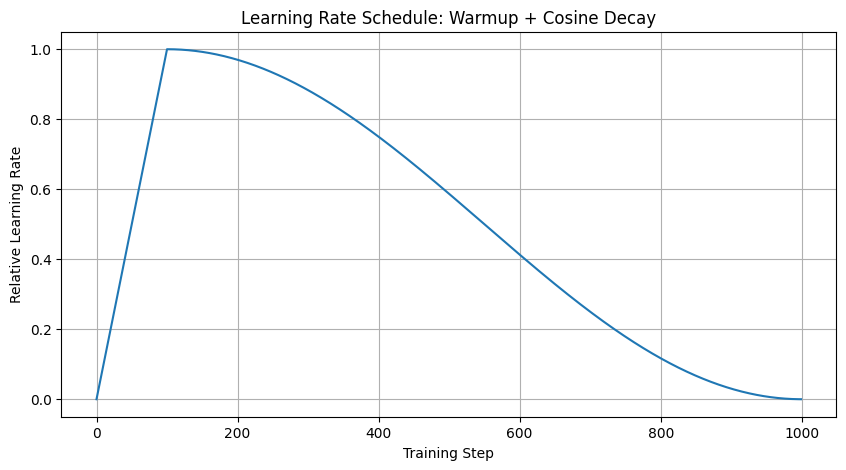

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import math

def get_lr_list(num_warmup_steps, num_training_steps, num_cycles=0.5):
    lr_list = []
    for step in range(num_training_steps):
        if step < num_warmup_steps:
            lr = float(step) / float(max(1, num_warmup_steps))
        else:
            progress = float(step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            lr = max(0.0, 0.5 * (1.0 + math.cos(math.pi * num_cycles * 2.0 * progress)))
        lr_list.append(lr)
    return lr_list

# 设定参数
num_training_steps = 1000
num_warmup_steps = 100
lr_list = get_lr_list(num_warmup_steps, num_training_steps)

# 画图
plt.figure(figsize=(10,5))
plt.plot(lr_list)
plt.title("Learning Rate Schedule: Warmup + Cosine Decay")
plt.xlabel("Training Step")
plt.ylabel("Relative Learning Rate")
plt.grid()
plt.show()


In [11]:
from tqdm import tqdm

In [12]:
def trainer(data_dir, segment_len, batch_size, n_wokers, d_model, dropout, lr, epochs, save_path, early_stop):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    criterion = nn.CrossEntropyLoss()
    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, segment_len = segment_len, batch_size = batch_size, n_workers = n_wokers)
    # for x, y in train_loader:
    #     print(x)
    #     print(y)
    #     assert 1 == 2
    model = Classifier(d_model = d_model, n_spks = speaker_num, dropout = dropout)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = lr)

    total_steps = len(train_loader) * epochs
    num_warmup_steps = int(total_steps * 0.07)
    scheduler = get_cosin_schedule_with_warmup(optimizer = optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = total_steps, num_cycles = 0.5, last_epoch = -1)

    best_loss = math.inf
    step = 0
    early_stop_count = 0

    for epoch in range(epochs):
        model.train()
        loss_record = []
        acc_record = []
        train_pbar = tqdm(train_loader, position = 0, leave = True)

        for x, y in train_pbar:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1
            acc = (pred.argmax(dim = -1) == y).float().mean()
            # print(acc.item())
            # assert 1 == 2
            loss_record.append(loss.item())
            acc_record.append(acc.item())

            train_pbar.set_description(f'Epoch [{epoch + 1}/{epochs}]')
            train_pbar.set_postfix({'Train loss': f'{loss.item():.5f}', 'Train acc': f'{acc.item():.5f}'})

        mean_train_acc = sum(acc_record) / len(acc_record)
        mean_train_loss = sum(loss_record) / len(loss_record)

        model.eval()
        loss_record = []
        acc_record = []
        valid_pbar = tqdm(valid_loader, position = 0, leave = True)
        
        for x, y in valid_pbar:
            with torch.no_grad():
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                acc = (pred.argmax(dim = -1) == y).float().mean()
                loss_record.append(loss.item())
                acc_record.append(acc.item())
                valid_pbar.set_description(f'Epoch [{epoch + 1}/{epochs}]')
                valid_pbar.set_postfix({'Valid loss': f'{loss.item():.5f}', 'Valid acc': f'{acc.item():.5f}'})
            
        mean_valid_acc = sum(acc_record) / len(acc_record)
        mean_valid_loss = sum(loss_record) / len(loss_record)
        print(f'Train Loss: {mean_train_loss:.5f}, Train Acc: {mean_train_acc:.5f}, Valid Loss: {mean_valid_loss:.5f}, Valid Acc: {mean_valid_acc:.5f}')

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), save_path)
            print(f'Save model with loss {best_loss:.3f}')
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= early_stop:
            print('\n Model is not improving, so we halt the training session.')
            return






In [13]:
trainer('./data/Dataset', 120, 64, 0, 80, 0.1, 1e-3, 35, './model.ckpt', 300)

Epoch [1/35]: 100%|██████████| 88/88 [01:08<00:00,  1.29it/s, Valid loss=5.42514, Valid acc=0.07812]


Train Loss: 6.15417, Train Acc: 0.00766, Valid Loss: 5.42314, Valid Acc: 0.03054
Save model with loss 5.423


Epoch [2/35]: 100%|██████████| 88/88 [00:03<00:00, 24.24it/s, Valid loss=3.99120, Valid acc=0.14062]


Train Loss: 4.78220, Train Acc: 0.08024, Valid Loss: 4.34415, Valid Acc: 0.13406
Save model with loss 4.344


Epoch [3/35]: 100%|██████████| 88/88 [00:02<00:00, 29.64it/s, Valid loss=3.65143, Valid acc=0.21875]


Train Loss: 3.99137, Train Acc: 0.17376, Valid Loss: 3.76106, Valid Acc: 0.21112
Save model with loss 3.761


Epoch [4/35]: 100%|██████████| 88/88 [00:02<00:00, 30.24it/s, Valid loss=3.02150, Valid acc=0.23438]


Train Loss: 3.50738, Train Acc: 0.25473, Valid Loss: 3.41812, Valid Acc: 0.26705
Save model with loss 3.418


Epoch [5/35]: 100%|██████████| 88/88 [00:02<00:00, 33.94it/s, Valid loss=3.31674, Valid acc=0.21875]


Train Loss: 3.18457, Train Acc: 0.30479, Valid Loss: 3.14789, Valid Acc: 0.31428
Save model with loss 3.148


Epoch [6/35]: 100%|██████████| 88/88 [00:03<00:00, 28.27it/s, Valid loss=2.76425, Valid acc=0.34375]


Train Loss: 2.94592, Train Acc: 0.34772, Valid Loss: 3.06248, Valid Acc: 0.33860
Save model with loss 3.062


Epoch [7/35]: 100%|██████████| 88/88 [00:02<00:00, 32.20it/s, Valid loss=2.56411, Valid acc=0.42188]


Train Loss: 2.78061, Train Acc: 0.38112, Valid Loss: 2.78794, Valid Acc: 0.37713
Save model with loss 2.788


Epoch [8/35]: 100%|██████████| 88/88 [00:03<00:00, 28.00it/s, Valid loss=2.73299, Valid acc=0.40625]


Train Loss: 2.63558, Train Acc: 0.40753, Valid Loss: 2.67635, Valid Acc: 0.41175
Save model with loss 2.676


Epoch [9/35]: 100%|██████████| 88/88 [00:02<00:00, 34.62it/s, Valid loss=2.75159, Valid acc=0.39062]


Train Loss: 2.50008, Train Acc: 0.43196, Valid Loss: 2.61594, Valid Acc: 0.42844
Save model with loss 2.616


Epoch [10/35]: 100%|██████████| 88/88 [00:02<00:00, 33.88it/s, Valid loss=1.97978, Valid acc=0.51562]


Train Loss: 2.38731, Train Acc: 0.45560, Valid Loss: 2.55179, Valid Acc: 0.43643
Save model with loss 2.552


Epoch [11/35]: 100%|██████████| 88/88 [00:03<00:00, 28.06it/s, Valid loss=2.08040, Valid acc=0.50000]


Train Loss: 2.28778, Train Acc: 0.47470, Valid Loss: 2.40563, Valid Acc: 0.46591
Save model with loss 2.406


Epoch [12/35]: 100%|██████████| 88/88 [00:03<00:00, 26.09it/s, Valid loss=2.10771, Valid acc=0.53125]


Train Loss: 2.19877, Train Acc: 0.49346, Valid Loss: 2.36730, Valid Acc: 0.47869
Save model with loss 2.367


Epoch [13/35]: 100%|██████████| 88/88 [00:03<00:00, 25.69it/s, Valid loss=2.58260, Valid acc=0.50000]


Train Loss: 2.10686, Train Acc: 0.51019, Valid Loss: 2.24998, Valid Acc: 0.49308
Save model with loss 2.250


Epoch [14/35]: 100%|██████████| 88/88 [00:02<00:00, 33.22it/s, Valid loss=1.76927, Valid acc=0.59375]


Train Loss: 2.04137, Train Acc: 0.52471, Valid Loss: 2.18922, Valid Acc: 0.50284
Save model with loss 2.189


Epoch [15/35]: 100%|██████████| 88/88 [00:03<00:00, 29.04it/s, Valid loss=2.02529, Valid acc=0.45312]


Train Loss: 1.95586, Train Acc: 0.54138, Valid Loss: 2.16043, Valid Acc: 0.51278
Save model with loss 2.160


Epoch [16/35]: 100%|██████████| 88/88 [00:03<00:00, 29.15it/s, Valid loss=2.26559, Valid acc=0.51562]


Train Loss: 1.90949, Train Acc: 0.55057, Valid Loss: 2.04867, Valid Acc: 0.53445
Save model with loss 2.049


Epoch [17/35]: 100%|██████████| 88/88 [00:03<00:00, 28.20it/s, Valid loss=1.53888, Valid acc=0.60938]


Train Loss: 1.85024, Train Acc: 0.56515, Valid Loss: 2.03594, Valid Acc: 0.54315
Save model with loss 2.036


Epoch [18/35]: 100%|██████████| 88/88 [00:03<00:00, 28.87it/s, Valid loss=2.08642, Valid acc=0.60938]


Train Loss: 1.80673, Train Acc: 0.57153, Valid Loss: 1.97844, Valid Acc: 0.55504
Save model with loss 1.978


Epoch [19/35]: 100%|██████████| 88/88 [00:02<00:00, 30.30it/s, Valid loss=1.76099, Valid acc=0.53125]


Train Loss: 1.74962, Train Acc: 0.58604, Valid Loss: 1.95697, Valid Acc: 0.55895
Save model with loss 1.957


Epoch [20/35]: 100%|██████████| 88/88 [00:02<00:00, 35.06it/s, Valid loss=1.43749, Valid acc=0.59375]


Train Loss: 1.69895, Train Acc: 0.59925, Valid Loss: 1.93776, Valid Acc: 0.57298
Save model with loss 1.938


Epoch [21/35]: 100%|██████████| 88/88 [00:03<00:00, 28.77it/s, Valid loss=2.06422, Valid acc=0.51562]


Train Loss: 1.65526, Train Acc: 0.60600, Valid Loss: 1.89136, Valid Acc: 0.57298
Save model with loss 1.891


Epoch [22/35]: 100%|██████████| 88/88 [00:03<00:00, 27.26it/s, Valid loss=2.03968, Valid acc=0.51562]


Train Loss: 1.60331, Train Acc: 0.61719, Valid Loss: 1.87863, Valid Acc: 0.57724
Save model with loss 1.879


Epoch [23/35]: 100%|██████████| 88/88 [00:02<00:00, 30.00it/s, Valid loss=2.37981, Valid acc=0.54688]


Train Loss: 1.56692, Train Acc: 0.62710, Valid Loss: 1.85886, Valid Acc: 0.57617
Save model with loss 1.859


Epoch [24/35]: 100%|██████████| 88/88 [00:02<00:00, 30.08it/s, Valid loss=2.04275, Valid acc=0.57812]


Train Loss: 1.53900, Train Acc: 0.63372, Valid Loss: 1.79807, Valid Acc: 0.59180
Save model with loss 1.798


Epoch [25/35]: 100%|██████████| 88/88 [00:03<00:00, 28.81it/s, Valid loss=1.67195, Valid acc=0.59375]


Train Loss: 1.50294, Train Acc: 0.63953, Valid Loss: 1.78110, Valid Acc: 0.60352
Save model with loss 1.781


Epoch [26/35]: 100%|██████████| 88/88 [00:03<00:00, 28.68it/s, Valid loss=1.33200, Valid acc=0.65625]


Train Loss: 1.48788, Train Acc: 0.64575, Valid Loss: 1.73918, Valid Acc: 0.60387
Save model with loss 1.739


Epoch [27/35]: 100%|██████████| 88/88 [00:02<00:00, 29.83it/s, Valid loss=2.72134, Valid acc=0.51562]


Train Loss: 1.45161, Train Acc: 0.65095, Valid Loss: 1.78696, Valid Acc: 0.60263


Epoch [28/35]: 100%|██████████| 88/88 [00:02<00:00, 29.95it/s, Valid loss=1.78551, Valid acc=0.56250]


Train Loss: 1.43410, Train Acc: 0.65753, Valid Loss: 1.72510, Valid Acc: 0.61275
Save model with loss 1.725


Epoch [29/35]: 100%|██████████| 88/88 [00:02<00:00, 31.19it/s, Valid loss=1.76560, Valid acc=0.56250]


Train Loss: 1.40923, Train Acc: 0.66487, Valid Loss: 1.74744, Valid Acc: 0.60760


Epoch [30/35]: 100%|██████████| 88/88 [00:03<00:00, 28.43it/s, Valid loss=1.45630, Valid acc=0.60938]


Train Loss: 1.38999, Train Acc: 0.66559, Valid Loss: 1.70614, Valid Acc: 0.61310
Save model with loss 1.706


Epoch [31/35]: 100%|██████████| 88/88 [00:03<00:00, 26.39it/s, Valid loss=1.59460, Valid acc=0.67188]


Train Loss: 1.37748, Train Acc: 0.67191, Valid Loss: 1.69990, Valid Acc: 0.61470
Save model with loss 1.700


Epoch [32/35]: 100%|██████████| 88/88 [00:03<00:00, 27.68it/s, Valid loss=1.73417, Valid acc=0.64062]


Train Loss: 1.36861, Train Acc: 0.67333, Valid Loss: 1.66039, Valid Acc: 0.62109
Save model with loss 1.660


Epoch [33/35]: 100%|██████████| 88/88 [00:03<00:00, 26.49it/s, Valid loss=2.06317, Valid acc=0.65625]


Train Loss: 1.35566, Train Acc: 0.67637, Valid Loss: 1.70120, Valid Acc: 0.61879


Epoch [34/35]: 100%|██████████| 88/88 [00:02<00:00, 34.95it/s, Valid loss=1.64796, Valid acc=0.57812]


Train Loss: 1.35079, Train Acc: 0.67698, Valid Loss: 1.68949, Valid Acc: 0.62216


Epoch [35/35]: 100%|██████████| 88/88 [00:02<00:00, 32.56it/s, Valid loss=1.53160, Valid acc=0.59375]

Train Loss: 1.34324, Train Acc: 0.68008, Valid Loss: 1.68658, Valid Acc: 0.61701


# 推理的准备工作

In [14]:
class InferenceDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        # mapping_path = self.data_dir / 'mapping.json'
        # id2speaker = json.load(mapping_path.open())['id2speaker']
        testdata_path = self.data_dir / 'testdata.json'
        testdata = json.load(testdata_path.open())['utterances']
        self.data = []
        for utterance in testdata:
            self.data.append(utterance['feature_path'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feat_path = self.data_dir / self.data[idx]
        mel = torch.load(feat_path)
        return self.data[idx], mel

In [15]:
test_dataset = InferenceDataset('./data/Dataset')
test_loader = DataLoader(test_dataset, 1, False)

In [16]:
test_dataset[0][0]

'uttr-b52ddeaacf1b42ff9c947eadce3e1966.pt'

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_best = Classifier()
model_best.load_state_dict(torch.load('./model.ckpt'))
model_best.to(device)

Classifier(
  (prenet): Linear(in_features=40, out_features=80, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=80, out_features=80, bias=True)
    )
    (linear1): Linear(in_features=80, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=80, bias=True)
    (norm1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (pred_layer): Sequential(
    (0): Linear(in_features=80, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=600, bias=True)
  )
)

In [18]:
mapping_path = Path('./data/Dataset/mapping.json')
id2speaker = json.load(mapping_path.open())['id2speaker']

# 正式推理

In [19]:
Id = []
Category = []
model_best.eval()
with torch.no_grad():
    for feat_path, mel in tqdm(test_loader):
        mel = mel.to(device)
        pred = model_best(mel)
        pred = pred.argmax(dim = -1)
        # assert 1 == 2
        Id.append(feat_path[0])
        Category.append(id2speaker[str(pred.item())])
        # break

100%|██████████| 8000/8000 [01:48<00:00, 73.52it/s]


# 保存结果

In [20]:
import pandas as pd

In [21]:
df = pd.DataFrame()
df['Id'] = Id
df["Category"] = Category
df.to_csv('submission.csv', index = False)

In [22]:
df

,Id,Category
0,uttr-b52ddeaacf1b42ff9c947eadce3e1966.pt,id03196
1,uttr-fc88b32cb5c94af6817ec97e0a145d74.pt,id09112
2,uttr-5c72e33935944ea692755ed5d2d8b0df.pt,id06044
3,uttr-7b23108157044861b524fb95e8183014.pt,id06042
4,uttr-f8ad4eed47d14d7198bc81552379ca0c.pt,id02231
...,...,...
7995,uttr-9f892aafd3394832bcd40e72823a39fb.pt,id03057
7996,uttr-44097dc4571b473799f7968314428f5d.pt,id06940
7997,uttr-f43a38e2addf4b239bc4057283444652.pt,id00508
7998,uttr-c7e5673a787a4874a63eb1961cd49b81.pt,id06311


In [23]:
1 / 600

0.0016666666666666668